## Decision Tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
outputVar = 'Risk'

X_train = train.drop(columns= [outputVar],axis=1)
y_train = train[outputVar]

X_test = test.drop(columns= [outputVar],axis=1)
y_test = test[outputVar]

### Vanilla Performance

In [4]:
from sklearn.tree import DecisionTreeClassifier

decTree = DecisionTreeClassifier(random_state=0)
_ = decTree.fit(X_train, y_train)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
myScore = cross_val_score(decTree, X_train, y_train, scoring = 'roc_auc', cv = myCV).mean()

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (training set).\n')

The cross-validation-score of this classifier is 0.6052002164502164 (training set).



In [6]:
from sklearn.metrics import roc_auc_score

y_pred = decTree.predict(X_test)

myScore = roc_auc_score(y_test, y_pred)

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (testing set).\n')

The cross-validation-score of this classifier is 0.5817144244779018 (testing set).



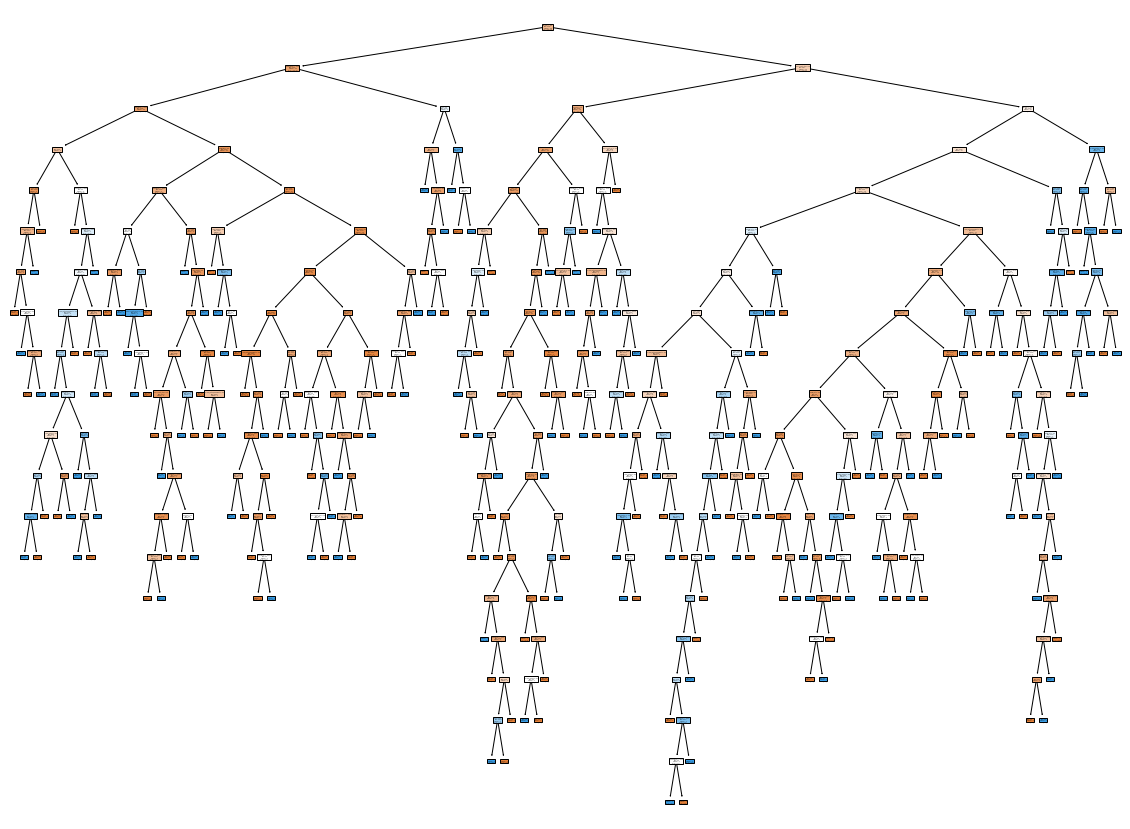

In [7]:
from sklearn import tree

fig = plt.figure(figsize=(20, 15))
_ = tree.plot_tree(decTree,
                   feature_names = X_train.keys(),
                   filled=True)
